<a href="https://colab.research.google.com/github/rohitrv8922/Face-Emotion-Recognition-Detection/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Project Introduction

Import Libraries

In [3]:
# Importing all the required Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(os.listdir("../input"))

In [5]:
df='/content/drive/My Drive/'
data = pd.read_csv(df+'/Dataset/icml_face_data.csv')


In [6]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()    


#5. Callback Functions

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

#6. More about the dataset

In [9]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

#7. Creating the label dictionary

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

#8. Training, Testing and Validation Split

In [11]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [12]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [13]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)


#9. Examples from the dataset

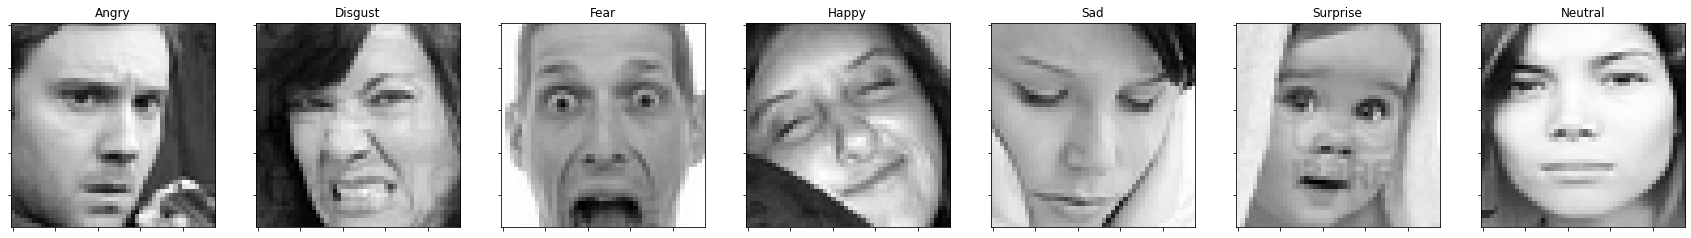

In [14]:
plot_all_emotions()

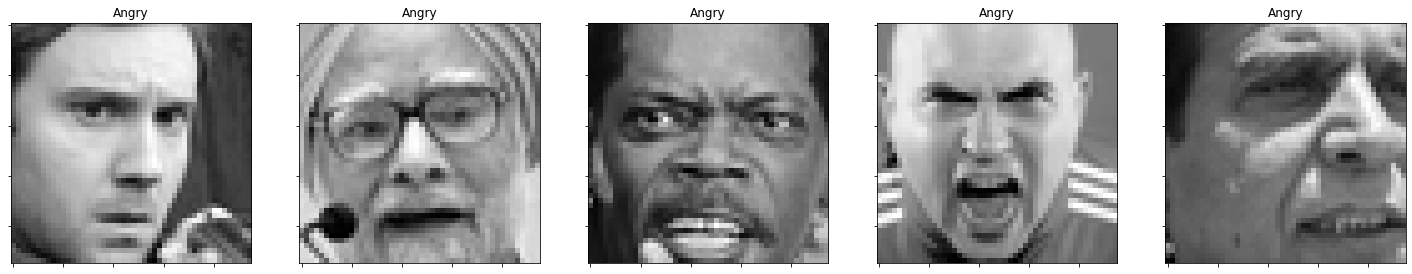

In [15]:
plot_examples(label=0)

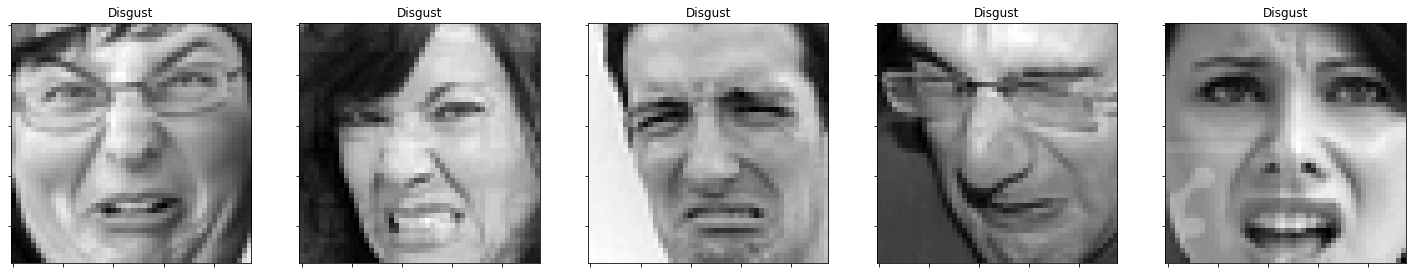

In [16]:
plot_examples(label=1)

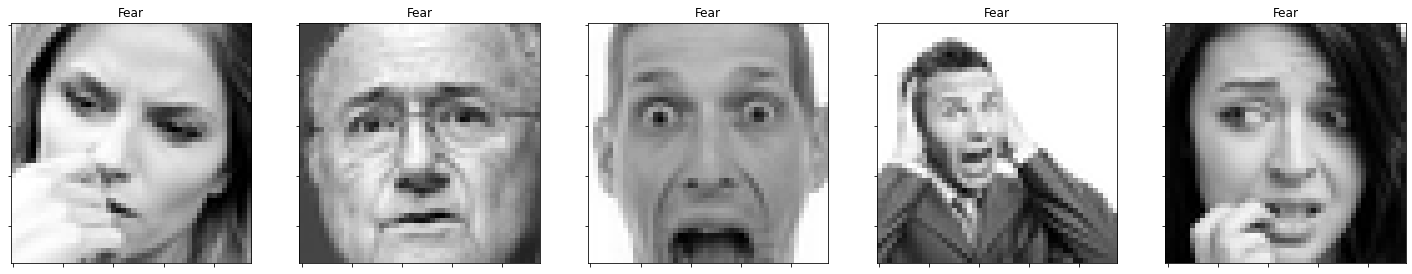

In [17]:
plot_examples(label=2)

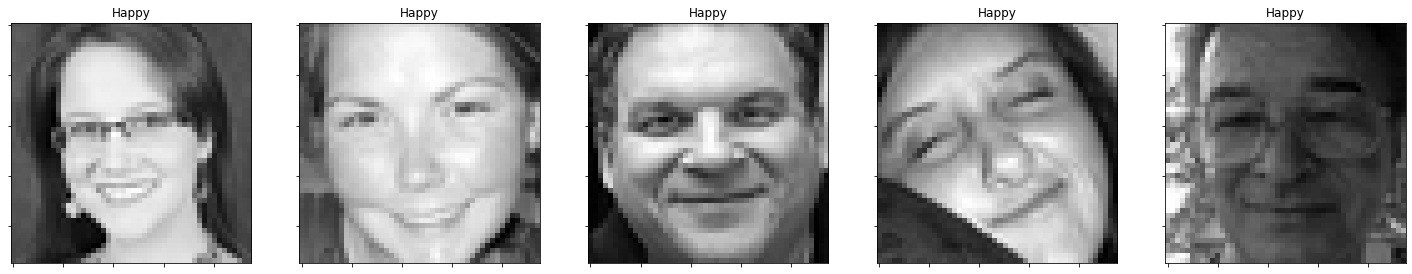

In [18]:
plot_examples(label=3)

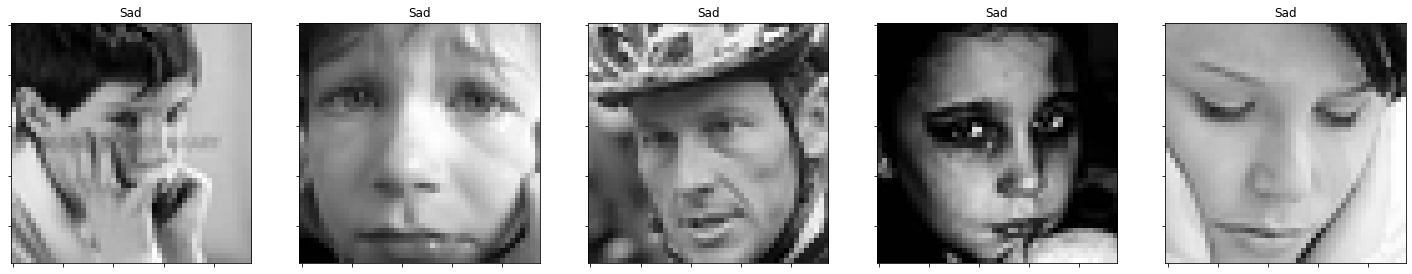

In [19]:
plot_examples(label=4)

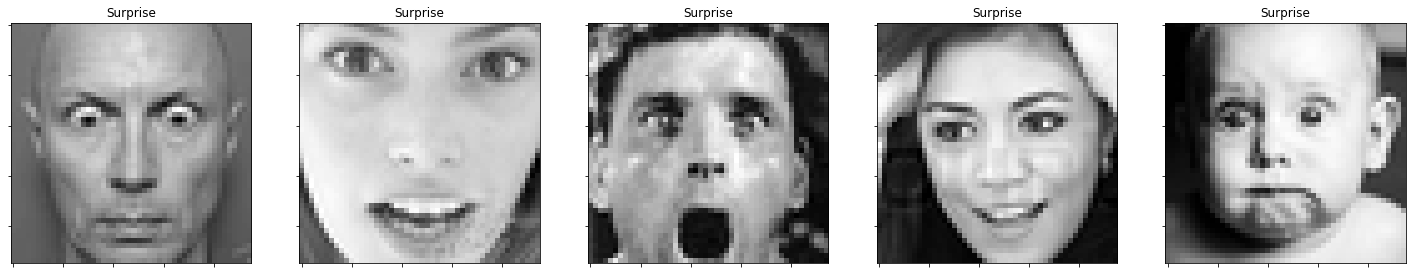

In [20]:
plot_examples(label=5)

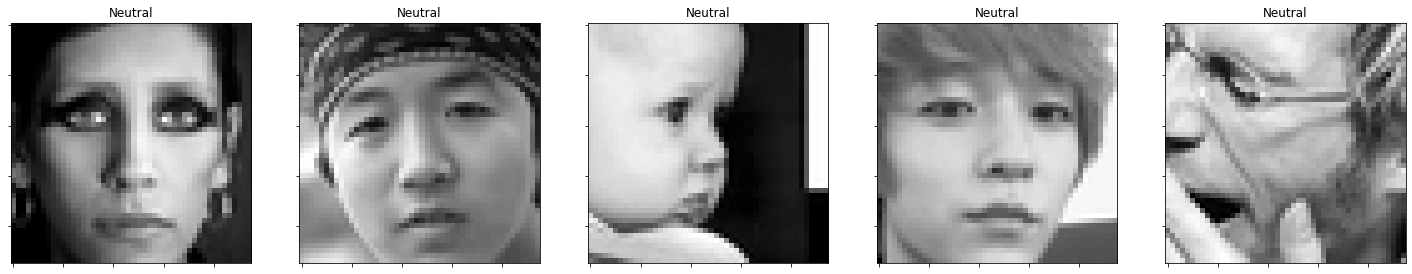

In [21]:
plot_examples(label=6)

#10. Comparison Plots

Train Labels and Validation Labels

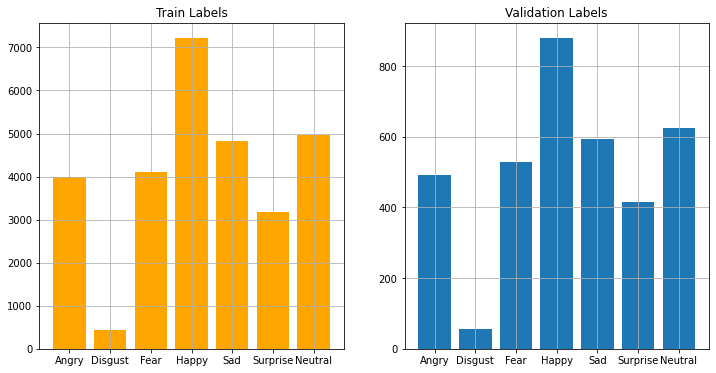

In [22]:
plot_compare_distributions(train_labels, val_labels, title1='Train Labels', title2='Validation Labels')

Train Labels and Test Labels

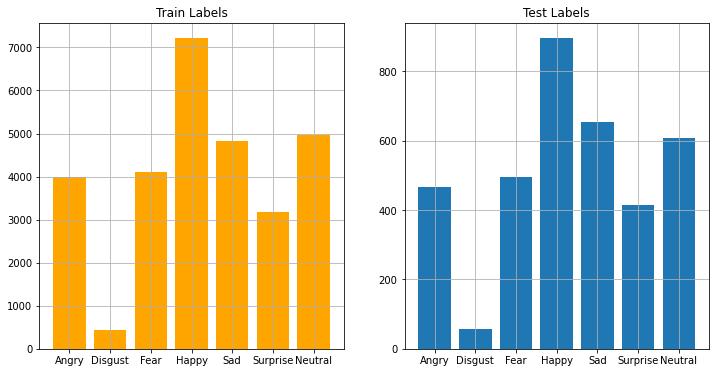

In [23]:
plot_compare_distributions(train_labels, test_labels, title1='Train Labels', title2='Test Labels')

#11. Weights

In [24]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

#12. Custom Model 1

With Convolution Layers, Pooldown Layers and Dense Layers

In [25]:
model1 = models.Sequential()

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))

model1.add(Dense(7, activation='softmax'))

#The Model

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

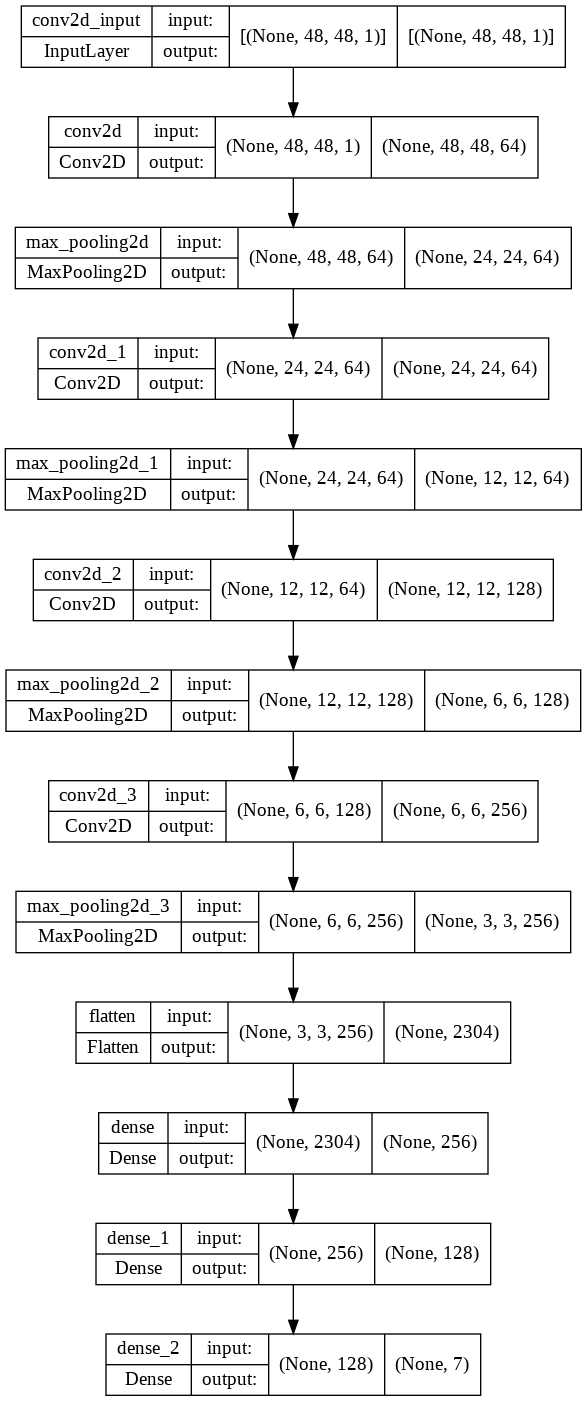

In [27]:
# Visualize the model.
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [28]:
model1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [29]:
history1 = model1.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_1'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.2997
Epoch 1: val_accuracy improved from -inf to 0.41516, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 17s 13ms/step - loss: 0.2719 - accuracy: 0.2997 - val_loss: 1.5616 - val_accuracy: 0.4152
Epoch 2/50
444/449 [============================>.] - ETA: 0s - loss: 0.2218 - accuracy: 0.4363
Epoch 2: val_accuracy improved from 0.41516 to 0.46197, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 11ms/step - loss: 0.2217 - accuracy: 0.4366 - val_loss: 1.4406 - val_accuracy: 0.4620
Epoch 3/50
447/449 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.5045
Epoch 3: val_accuracy improved from 0.46197 to 0.50989, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 11ms/step - loss: 0.1974 - accuracy: 0.5044 - val_loss: 1.3189 - val_accuracy: 0.5099
Epoch 4/50
444/449 [================

In [30]:
model1.save("fer.h5")

In [31]:
new_model1=tf.keras.models.load_model('fer.h5')

In [32]:
from tensorflow.keras.models import load_model
loaded_model1=load_model('fer.h5')

Accuracy

In [33]:
train_loss, train_acc = model1.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 4s 4ms/step - loss: 0.1557 - accuracy: 0.9556
Training Accuracy: 95.55888175964355


113/113 [==============================] - 1s 4ms/step - loss: 2.7457 - accuracy: 0.5684
Testing Accuracy: 56.84034824371338


113/113 [==============================] - 1s 4ms/step - loss: 2.5961 - accuracy: 0.5692
Validation Accuracy: 56.92393183708191


Predictions

In [34]:
pred_test_labels1 = model1.predict(test_images)

Plots

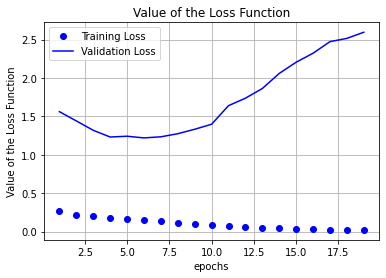

In [35]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Value of the Loss Function')
plt.xlabel('epochs')
plt.ylabel('Value of the Loss Function')
plt.legend()
plt.grid()
plt.show()

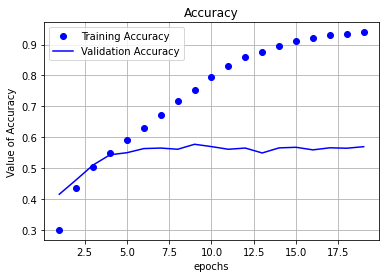

In [56]:
acc = history1.history['accuracy']
acc_val = history1.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Value of Accuracy')
plt.legend()
plt.grid()
plt.show()

#13. Custom Model 2

With Convolution Layers, Pooldown Layers, Dropout Layers and Dense Layers

In [57]:
model2 = models.Sequential()

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

The Model

In [58]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                  

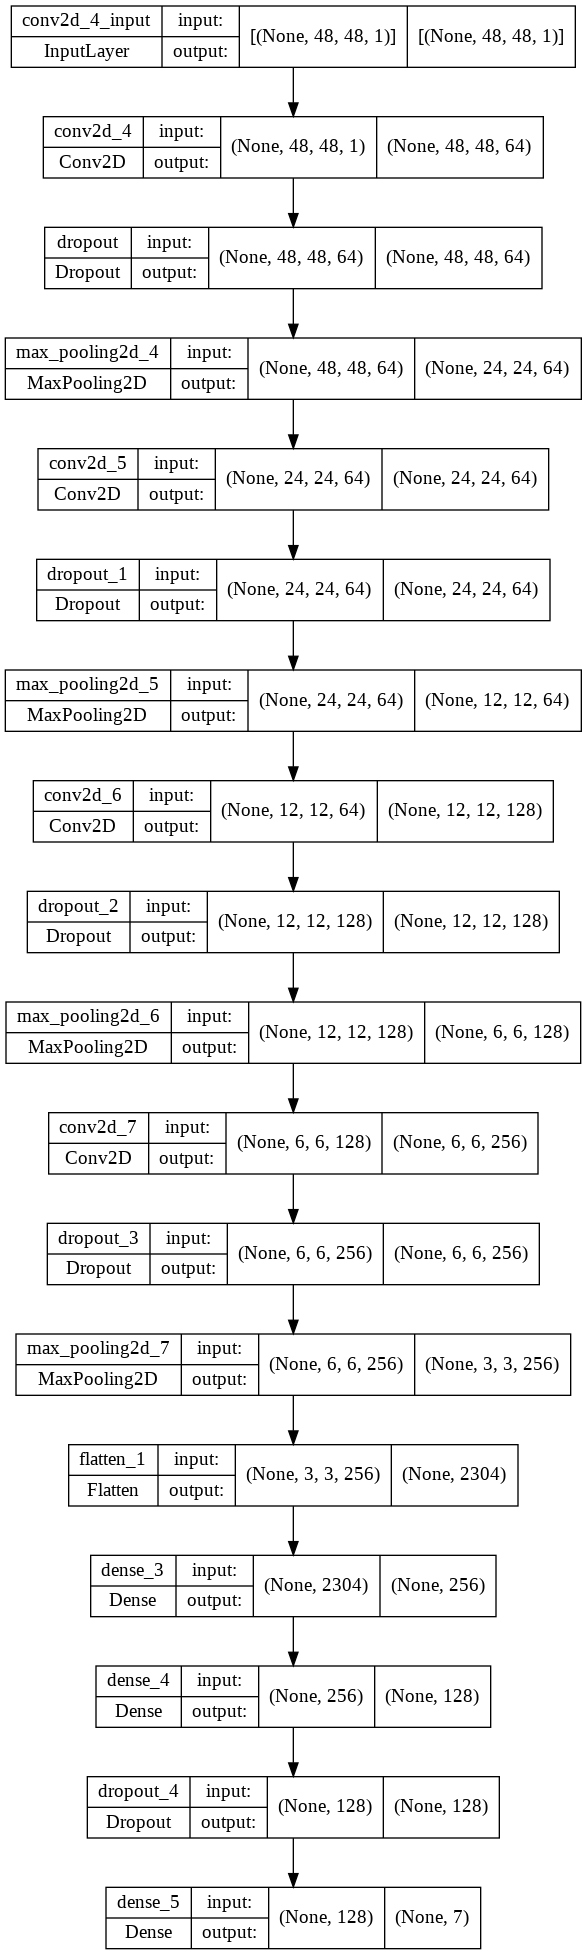

In [59]:
# Visualize the model.
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [60]:
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [61]:
history2 = model2.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_2'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
447/449 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.2836
Epoch 1: val_accuracy improved from -inf to 0.32126, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 8s 16ms/step - loss: 0.2794 - accuracy: 0.2836 - val_loss: 1.6609 - val_accuracy: 0.3213
Epoch 2/50
447/449 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.4045
Epoch 2: val_accuracy improved from 0.32126 to 0.42965, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2369 - accuracy: 0.4045 - val_loss: 1.4980 - val_accuracy: 0.4296
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.4631
Epoch 3: val_accuracy improved from 0.42965 to 0.47590, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2146 - accuracy: 0.4631 - val_loss: 1.3859 - val_accuracy: 0.4759
Epoch 4/50
449/449 [=================

In [62]:
model2.save('fer.h5')

In [63]:
new_model2=tf.keras.models.load_model('fer.h5')

In [64]:
from tensorflow.keras.models import load_model
loaded_model2=load_model('fer.h5')

Accuracy

In [65]:
train_loss, train_acc = model2.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 4s 4ms/step - loss: 0.4807 - accuracy: 0.8553
Training Accuracy: 85.53066849708557


113/113 [==============================] - 1s 5ms/step - loss: 1.2900 - accuracy: 0.5673
Testing Accuracy: 56.728893518447876


113/113 [==============================] - 1s 5ms/step - loss: 1.2787 - accuracy: 0.5745
Validation Accuracy: 57.453328371047974


Predictions

In [66]:
pred_test_labels2 = model2.predict(test_images)

Plots

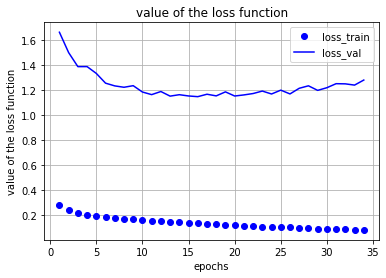

In [67]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

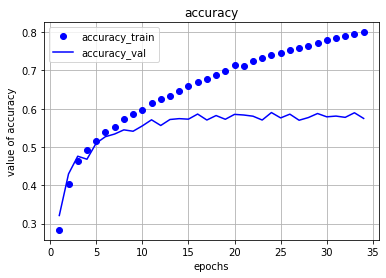

In [68]:
acc = history2.history['accuracy']
acc_val = history2.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#14. Custom Model 3

With Convolution Layers, Pooldown Layer, Droupout Layers, Batch Normalization and Dense Layers

In [69]:
model3 = models.Sequential()

model3.add(Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2),padding="same"))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

The Model

In [70]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        128       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 128)      

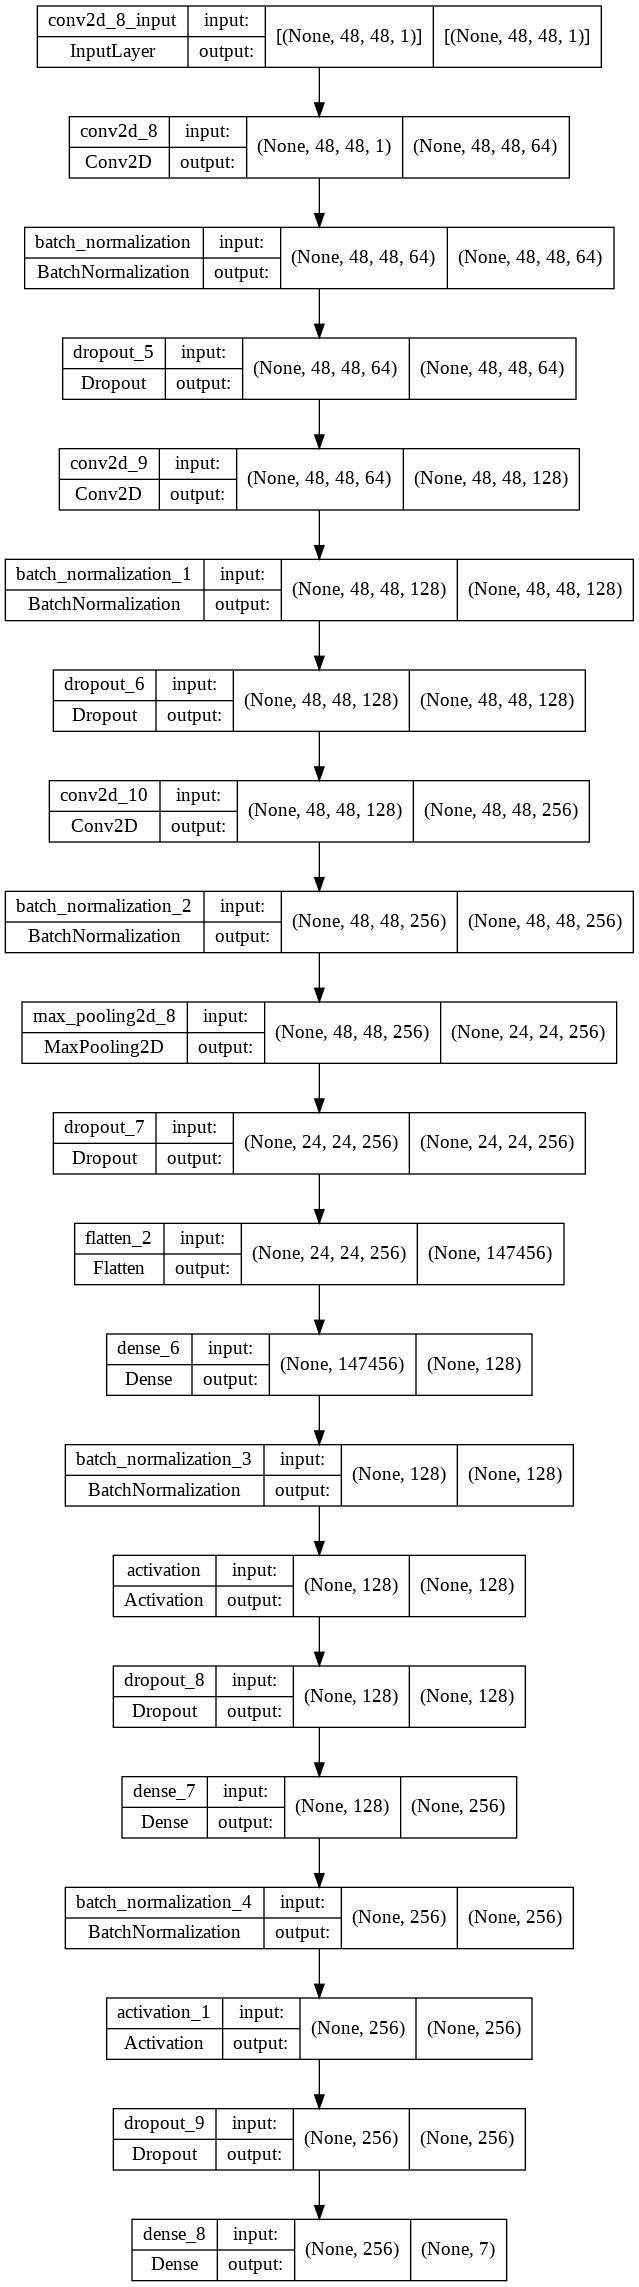

In [71]:
# Visualize the model.
plot_model(model3, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [72]:
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [73]:
history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_3'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.3228
Epoch 1: val_accuracy improved from -inf to 0.36528, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 50s 103ms/step - loss: 0.2797 - accuracy: 0.3228 - val_loss: 1.6566 - val_accuracy: 0.3653
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.4367
Epoch 2: val_accuracy improved from 0.36528 to 0.48091, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 43s 95ms/step - loss: 0.2269 - accuracy: 0.4367 - val_loss: 1.3740 - val_accuracy: 0.4809
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.5078
Epoch 3: val_accuracy improved from 0.48091 to 0.50181, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 43s 96ms/step - loss: 0.1993 - accuracy: 0.5078 - val_loss: 1.3163 - val_accuracy: 0.5018
Epoch 4/50
449/449 [=============

In [74]:
model3.save('fer.h5')

In [75]:
new_model3=tf.keras.models.load_model('fer.h5')

In [76]:
from tensorflow.keras.models import load_model
loaded_model3=load_model('fer.h5')

Accuracy

In [77]:
train_loss, train_acc = model3.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model3.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 13s 14ms/step - loss: 0.0230 - accuracy: 0.9922
Train Accuracy: 99.22323822975159


113/113 [==============================] - 2s 14ms/step - loss: 2.6170 - accuracy: 0.5614
Test Accuracy: 56.1437726020813


113/113 [==============================] - 2s 13ms/step - loss: 2.4710 - accuracy: 0.5690
Validation Accuracy: 56.89607262611389


Predictions

In [78]:
pred_test_labels3 = model3.predict(test_images)

Plots

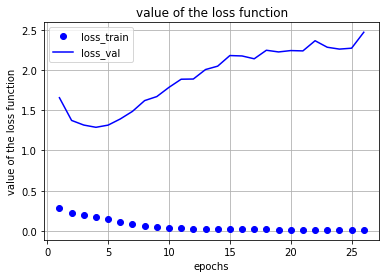

In [79]:
loss = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

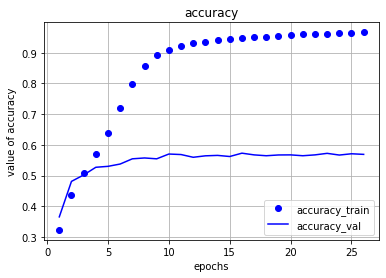

In [80]:
acc = history3.history['accuracy']
acc_val = history3.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#15. Analyzing the Results

For Model 1

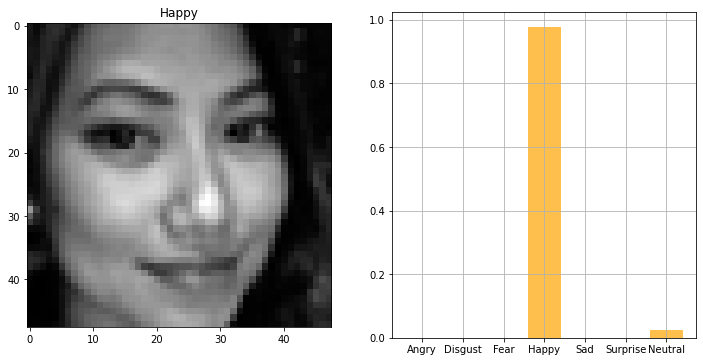

In [81]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 19)

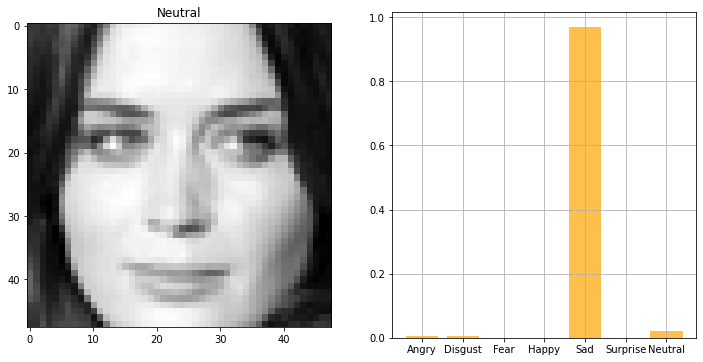

In [82]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 119)

Form Model 2

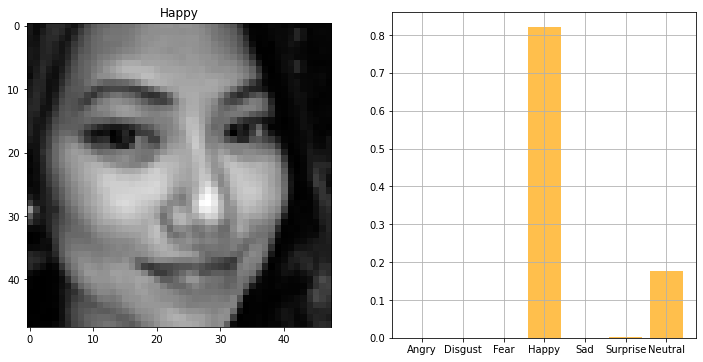

In [83]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 19)

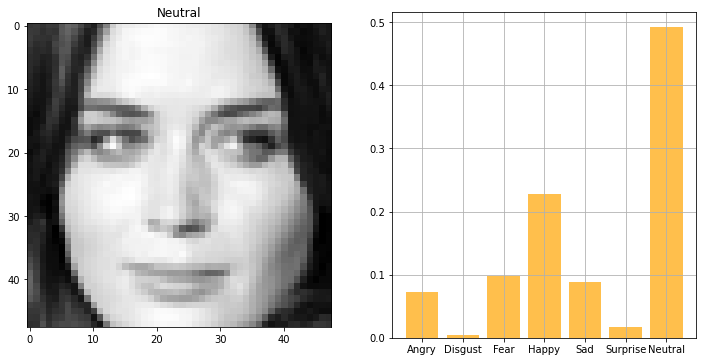

In [84]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 119)

For Model 3

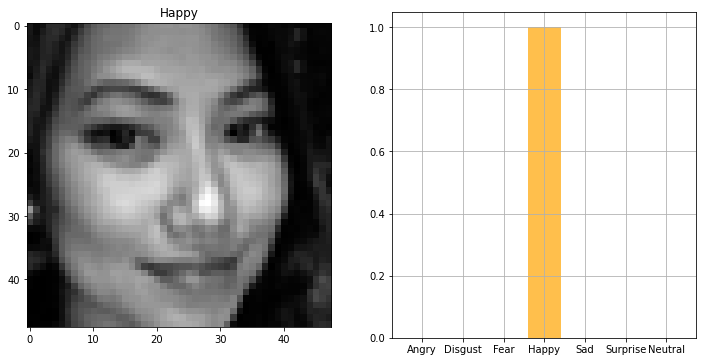

In [85]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 19)

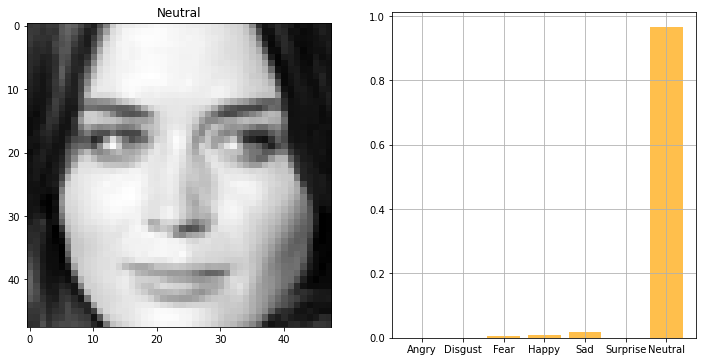

In [86]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 119)

16. Predicted Label Comparision Plot

Model 1

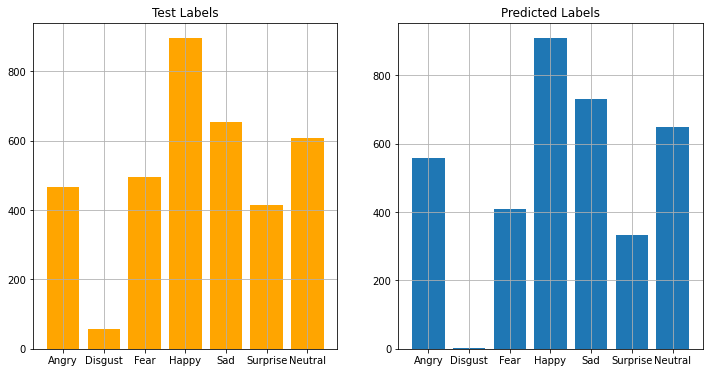

In [87]:
plot_compare_distributions(test_labels, pred_test_labels1, title1='Test Labels', title2='Predicted Labels')

Model 2

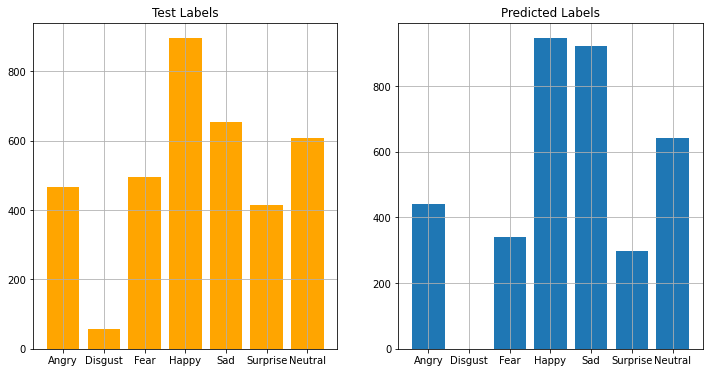

In [88]:
plot_compare_distributions(test_labels, pred_test_labels2, title1='Test Labels', title2='Predicted Labels')

Model 3

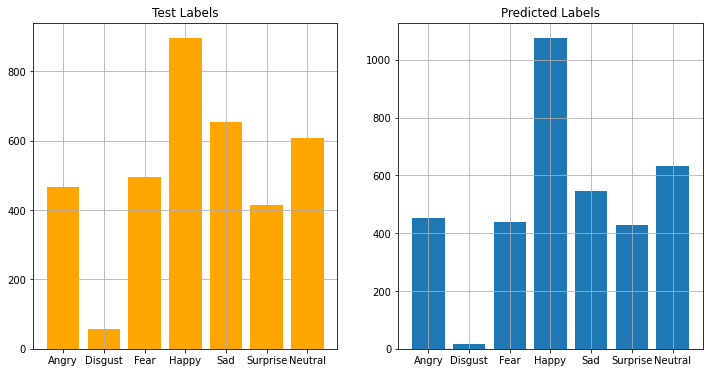

In [89]:
plot_compare_distributions(test_labels, pred_test_labels3, title1='Test Labels', title2='Predicted Labels')

#17. Analysis of Incorrect Prediction

We are using Confusion Matrix in this case.

Model 1

In [90]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels1.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

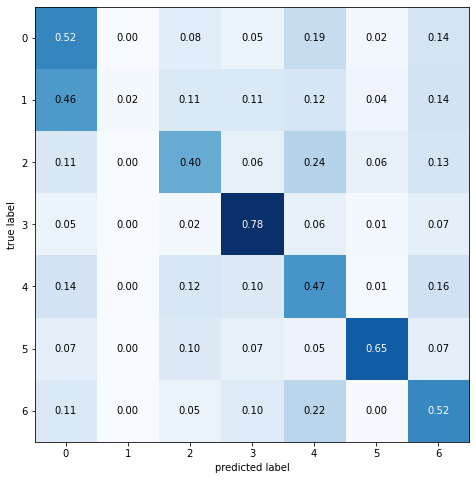

In [91]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels1.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Model 2

In [92]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

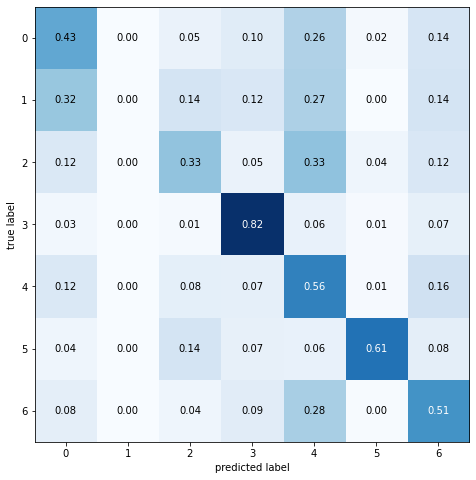

In [93]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels2.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Model 3

In [94]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

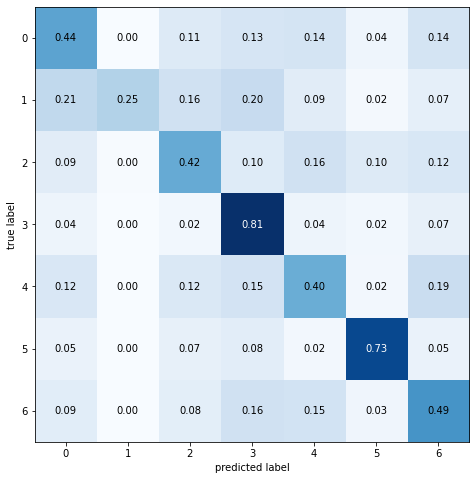

In [95]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels3.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

In [96]:
!pip3 install virtualenv
!virtualenv theanoEnv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
created virtual environment CPython3.7.13.final.0-64 in 233ms
  creator CPython3Posix(dest=/content/theanoEnv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: Theano==1.0.5, numpy==1.21.6, pip==22.2.2, robotframework==5.0.1, scipy==1.7.3, setuptools==63.4.1, six==1.16.0, wheel==0.37.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [97]:
!source /content/theanoEnv/bin/activate; pip3 install theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
!source /content/theanoEnv/bin/activate; pip3 install robotframework; pip3 list; python3 -m robot --help

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Package        Version
-------------- -------
numpy          1.21.6
pip            22.2.2
robotframework 5.0.1
scipy          1.7.3
setuptools     63.4.1
six            1.16.0
Theano         1.0.5
wheel          0.37.1
Robot Framework -- A generic automation framework

Version:  5.0.1 (Python 3.7.13 on linux)

Usage:  robot [options] paths
   or:  python -m robot [options] paths
   or:  python path/to/robot [options] paths

Robot Framework is a generic open source automation framework for acceptance
testing, acceptance test-driven development (ATDD) and robotic process
automation (RPA). It has simple, easy-to-use syntax that utilizes the
keyword-driven automation approach. Keywords adding new capabilities are
implemented in libraries using Python. New higher level
keywords can also be created using Robot Framework's own syntax.

The easiest way to execute Robot Framework is using the `rob

In [99]:
fer_json = model1.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model1.save_weights("fer.h5")

In [100]:
from flask import Flask, render_template, Response
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json  
from tensorflow.keras.preprocessing import image  

In [101]:

model = model_from_json(open("fer.json", "r").read())  #load model  

model.load_weights('fer.h5')                            #load weights  

face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

camera = cv2.VideoCapture(0)

app = Flask(__name__)

In [102]:
def gen_frames():                                       # generate frame by frame from camera
    while True:
        # Capture frame by frame
        success, frame = camera.read()
        if not success:
            break
        else:
            gray_img= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
        
            faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  
            
        
            for (x,y,w,h) in faces_detected:
                
                cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
                roi_gray=gray_img[y:y+w,x:x+h]          #cropping region of interest i.e. face area from  image  
                roi_gray=cv2.resize(roi_gray,(48,48))  
                img_pixels = image.img_to_array(roi_gray)  
                img_pixels = np.expand_dims(img_pixels, axis = 0)  
                img_pixels /= 255  
        
                predictions = model.predict(img_pixels)  
        
                max_index = np.argmax(predictions[0])   #find max indexed array
        
                emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  
                predicted_emotion = emotions[max_index]  
                
                cv2.putText(frame, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  
        
            resized_img = cv2.resize(frame, (1000, 700))  
            
            ret, buffer = cv2.imencode('.jpg', frame)
            
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')  # concat frame one by one and show result


@app.route('/video_feed')
def video_feed():
    return Response(gen_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')


@app.route('/')
def index():
    return render_template('index.html')


if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug: * Restarting with stat


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
!doctype html
html lang="en"
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1">

    <!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">

    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
    <meta name="description" content="">
    <meta name="viewport" content="width=device-width, initial-scale=1">

    <link rel="stylesheet" href="css/bootstrap.min.css">
    <link rel="stylesheet" href="css/fontAwesome.css">
    <link rel="stylesheet" href="css/templatemo-main.css">

    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/css/bootstrap.min.css"
          integrity="sha384-MCw98/SFnGE8fJT3GXwEOngsV7Zt27NXFoaoApmYm81iuXoPkFOJwJ8ERdknLPMO" crossorigin="anonymous">

    <title>Real Time Emotion Detection</title>
</head>
<body style="background-color:#002147;">
    <div class="parallax-content baner-content" id="home">
        <div class="container">
            <div class="row">
                <div class="col-lg-8  offset-lg-2">
                    <h3 class="mt-5"><font color="white" style="font-family:verdana;" style="font-size:300%;"> Real Time Emotion Detection</font></h3>
                    <img src="{{ url_for('video_feed') }}" width="100%">
                </div>
            </div>
        </div>
    </div>
</body>
</html>